# Difference-in-Differences between specific region and others

In [399]:
import numpy as np
import pandas as pd
from typing import Optional
from matplotlib import pyplot as plt
from pydantic import BaseModel
import matplotlib.ticker as plticker
import seaborn as sns
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [482]:
class DiDResult(BaseModel):
    intervention_year: int
    treatment_var_name: str
    treatment_value: str
    control_value: str
    analysis: str

In [586]:
outcome_var = "log_measurement"
intervention_year: Optional[int] = 2015
intervention_year: Optional[int] = None

multicat_treatment_var = "Regions"

# multicat_treatment_var_value = "Gulf of Mexico"
multicat_treatment_var_value = "Mediterranean Sea"
multicat_treatment_var_value = "North Sea"
multicat_treatment_var_value = "Gulf of California"
multicat_treatment_var_value = "Caribbean Sea"

treatment_var = "target_region"
treatment_var_value = 1

control_var_dummy_value = "Other Seas"

covars_except_treatment = "C(year) + C(neuston_net)"

filepath = "/mnt/d/temp/user/ed/mart/mmplastic/Marine_Microplastics_WGS84_1130715472761438990.csv"

In [587]:
df = pd.read_csv(filepath)
df = df.dropna(subset=["Measurement"])
df['yyyymmdd'] = pd.to_datetime(df['Date'])
df['year'] = df['yyyymmdd'].dt.year
df['month'] = df['yyyymmdd'].dt.month
df['day'] = df['yyyymmdd'].dt.day

df["neuston_net"] = (df["Sampling Method"] == "Neuston net").apply(lambda x: int(x))
df = df.rename(columns={"Density Class": "density"})
df = df.drop(columns=["Sampling Method"])

df["measurement"] = np.where(df["Measurement"] > 1.0, 1.0, df["Measurement"])
df["log_measurement"] = np.log(df["measurement"])

/tmp/ipykernel_218711/2866255947.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['yyyymmdd'] = pd.to_datetime(df['Date'])
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Binarize Region var.

In [592]:
df[treatment_var] = (df[multicat_treatment_var] == multicat_treatment_var_value).apply(lambda x: int(x))

## Min and Max Year of Treatment Var.

In [593]:
year_range = df[df[treatment_var] == treatment_var_value].agg({"year": ["min", "max"]})
year_range

,year
min,1986
max,2021


In [594]:
year_range = df[df[treatment_var] == treatment_var_value].agg({"year": ["min", "max"]})
if intervention_year is None:
    intervention_year = int((year_range.loc["min"] + (year_range.loc["max"] - year_range.loc["min"])/2).loc["year"])
(
    year_range,
    intervention_year
)

(     year
 min  1986
 max  2021,
 2003)

## Find lower/higher quantile thresholds

In [595]:
def find_quantile_below_threshold(df, column, threshold, quantile_range=(0, 1, 0.005)):
  """
  Finds the highest quantile value less than a given threshold in a Pandas DataFrame column.

  Args:
    df: The Pandas DataFrame.
    column: The name of the column to check.
    threshold: The threshold value.
    quantile_range: A tuple defining the start, end, and step of the quantile range.

  Returns:
    The quantile value that is less than the threshold.
  """

  quantiles = np.arange(*quantile_range)
  for q in quantiles[::-1]:
    quantile_value = df[column].quantile(q)
    if quantile_value < threshold:
      return q, quantile_value
  return None, None  # If no quantile is found

threshold = 0.0
quantile, value = find_quantile_below_threshold(df, 'log_measurement', threshold)
print("Quantile:", quantile)
print("Value:", value)

higher_quantile = quantile

Quantile: 0.86
Value: -0.024470811007744744


In [596]:
def find_quantile_over_threshold(df, column, threshold, quantile_range=(0, 1, 0.005)):
  """
  Finds the lowest quantile value less than a given threshold in a Pandas DataFrame column.

  Args:
    df: The Pandas DataFrame.
    column: The name of the column to check.
    threshold: The threshold value.
    quantile_range: A tuple defining the start, end, and step of the quantile range.

  Returns:
    The quantile value that is less than the threshold.
  """

  quantiles = np.arange(*quantile_range)
  for q in quantiles:
    quantile_value = df[column].quantile(q)
    if quantile_value > threshold:
      return q, quantile_value
  return None, None  # If no quantile is found

threshold = -10.0
quantile, value = find_quantile_over_threshold(df, outcome_var, threshold)
print("Quantile:", quantile)
print("Value:", value)

lower_quantile = quantile

Quantile: 0.32
Value: -6.907755278982137


/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: inva

In [597]:
higher_threshold = np.ceil(df[outcome_var].quantile(higher_quantile) * 100.) / 100.
lower_threshold = np.ceil(df[outcome_var].quantile(lower_quantile) * 1000.) / 1000.

In [598]:
df2 = df.loc[
    (df[outcome_var] > lower_threshold) & (df[outcome_var] < higher_threshold),
    # (df[outcome_var] > lower_threshold) & (df[outcome_var] < higher_threshold) & (df["Oceans"].isin(["Pacific Ocean", "Atlantic Ocean"])),
    :
]

<Axes: xlabel='log_measurement', ylabel='Count'>

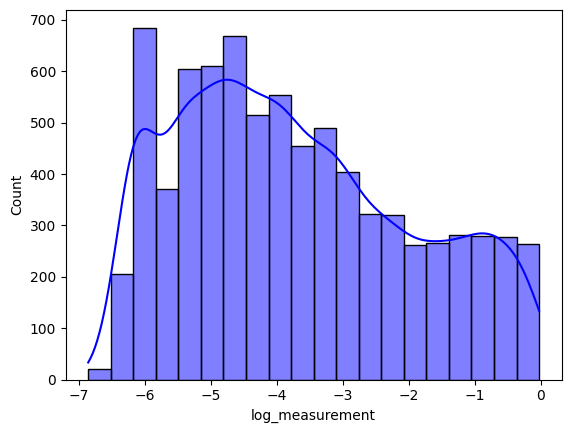

In [599]:
sns.histplot(
    data=df2,
    x="log_measurement",
    bins=20,
    kde=True,
    color="blue",
    alpha=0.5,
)

In [600]:
preproc_df = df2
df = df2

In [601]:
df

,OBJECTID,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,density,Short Reference,Long Reference,DOI,Organization,Keywords,Accession Number,Accession Link,Latitude,Longitude,Date,GlobalID,x,y,yyyymmdd,year,month,day,neuston_net,measurement,log_measurement,target_region
0,9676,Atlantic Ocean,NaN,NaN,0.018000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,-31.696000,-48.560000,8/11/2015 12:00:00 AM,a77121b2-e113-444e-82d9-7af11d62fdd2,-48.560000,-31.696000,2015-08-11,2015,8,11,0,0.018000,-4.017384,0
2,10672,Pacific Ocean,NaN,NaN,0.013000,pieces/m3,0.005-1,Medium,Goldstein et al.2013,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",https://doi.org/10.1371/journal.pone.0080020,Scripps Institution of Oceanography-University...,Great Pacific Garbage Patch/SEAPLEX,253448,https://www.ncei.noaa.gov/access/metadata/land...,0.500000,-95.350000,10/17/2006 12:00:00 AM,23effcdd-35b7-4e1e-adb4-390693a287d3,-95.350000,0.500000,2006-10-17,2006,10,17,0,0.013000,-4.342806,0
6,11597,Pacific Ocean,NaN,NaN,0.631646,pieces/m3,0.005-1,Medium,Eriksen et al.2014,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",https://doi.org/10.1371/journal.pone.0111913,5 Gyres Institute,SV Mir; ORV Alguita; SV Sea Dragon; RV Stad Am...,275968,https://www.ncei.noaa.gov/access/metadata/land...,19.340300,-156.087000,11/24/2007 12:00:00 AM,f9f3119e-d9ae-487c-93d6-27f02e4bb44d,-156.087000,19.340300,2007-11-24,2007,11,24,1,0.631646,-0.459426,0
7,8348,Pacific Ocean,NaN,NaN,0.008640,pieces/m3,0.005-1,Medium,Law et al.2014,"Law, K.L, S.K. Morét-Ferguson, D.S. Goodwin, E...",https://doi.org/10.1021/es4053076,Sea Education Association,SEA,211008,https://www.ncei.noaa.gov/access/metadata/land...,33.470000,-151.630000,12/10/2011 12:00:00 AM,be818f7e-f16b-4811-9763-054a6a400e08,-151.630000,33.470000,2011-12-10,2011,12,10,1,0.008640,-4.751353,0
9,14253,Atlantic Ocean,North Sea,NaN,0.004425,pieces/m3,0.0005-0.005,Low,"Russell and Webster, 2021","Russell, M., L. Webster. 2021. Microplastics i...",https://doi.org/10.1016/j.marpolbul.2021.112210,Marine Scotland Science,MRV Scotia/MRV Alba na Mara /RV Sir John Murray,259692,https://www.ncei.noaa.gov/access/metadata/land...,58.034333,-3.627833,1/18/2019 12:00:00 AM,8f5b8816-6e22-46b0-ba41-6aac40dcc072,-3.627833,58.034333,2019-01-18,2019,1,18,1,0.004425,-5.420485,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20415,9212,Atlantic Ocean,NaN,NaN,0.006000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.801700,-38.190000,12/5/2014 12:00:00 AM,6bc79c43-0572-4da8-8f45-4275e0a2e95c,-38.190000,17.801700,2014-12-05,2014,12,5,0,0.006000,-5.115996,0
20416,8917,Atlantic Ocean,NaN,NaN,0.004000,pieces/m3,0.0005-0.005,Low,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,22.341300,-19.952500,11/12/2014 12:00:00 AM,fa761396-9019-4c6a-a7e5-a4822a8f2926,-19.952500,22.341300,2014-11-12,2014,11,12,0,0.004000,-5.521461,0
20419,9366,Atlantic Ocean,NaN,NaN,0.011000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.100000,-47.550000,2/1/2015 12:00:00 AM,fd4db6d6-aed7-48b1-a22b-402557112e2f,-47.550000,17.100000,2015-02-01,2015,2,1,0,0.011000,-4.509860,0
20420,4683,Atlantic Ocean,Caribbean 

In [602]:
len(df[df["Oceans"] == "Pacific Ocean"]), len(df[df["Oceans"] == "Atlantic Ocean"])

(1731, 6005)

In [603]:
df[df["Oceans"] == "Pacific Ocean"]["year"]

2        2006
6        2007
7        2011
13       2005
58       2010
         ... 
20343    2008
20367    2004
20372    2010
20387    2015
20389    2011
Name: year, Length: 1731, dtype: int32

<Axes: xlabel='year', ylabel='Count'>

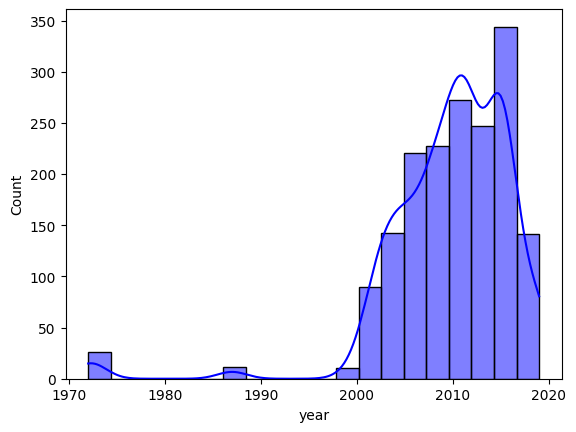

In [604]:
sns.histplot(
    data=df[df["Oceans"] == "Pacific Ocean"],
    x="year",
    bins=20,
    kde=True,
    color="blue",
    alpha=0.5,
)

<Axes: xlabel='year', ylabel='Count'>

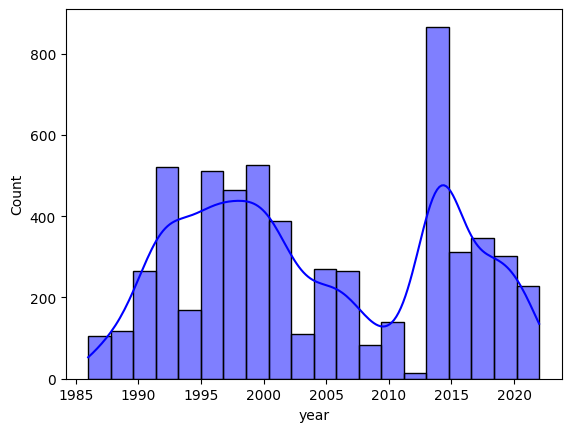

In [605]:
sns.histplot(
    data=df[df["Oceans"] == "Atlantic Ocean"],
    x="year",
    bins=20,
    kde=True,
    color="blue",
    alpha=0.5,
)

## Set post variable
- potential intervention year

In [606]:
df["post"] = (df["year"] > intervention_year).apply(lambda a: int(a))

/tmp/ipykernel_218711/2549983103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["post"] = (df["year"] > intervention_year).apply(lambda a: int(a))


## Set treated
- intervention region

In [607]:
treatment_condition = (df[treatment_var] == treatment_var_value)
control_condition = (df[treatment_var] != treatment_var_value)

In [608]:
df["treated"] = (treatment_condition).apply(lambda a: int(a))
# df["treated"] = (df["Oceans"] == "Pacific Ocean").apply(lambda a: int(a))

/tmp/ipykernel_218711/1021480123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["treated"] = (treatment_condition).apply(lambda a: int(a))


In [609]:
df1 = df[control_condition & (df["post"] == False)]
df1 = df1.assign(dataset=f'{control_var_dummy_value}-Prev')

df2 = df[control_condition & (df["post"] == True)]
df2 = df2.assign(dataset=f'{control_var_dummy_value}-Post')

df3 = df[treatment_condition & (df["post"] == False)]
df3 = df3.assign(dataset=f'{treatment_var_value}-Prev')

df4 = df[treatment_condition & (df["post"] == True)]
df4 = df4.assign(dataset=f'{treatment_var_value}-Post')


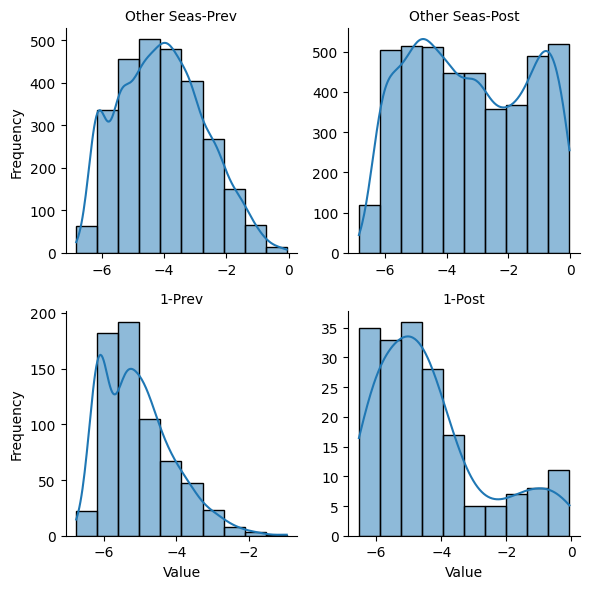

In [610]:
blocks_df = pd.DataFrame({
    f"{control_var_dummy_value}-Prev": df1[outcome_var],
    f"{control_var_dummy_value}-Post": df2[outcome_var],
    f"{treatment_var_value}-Prev": df3[outcome_var],
    f"{treatment_var_value}-Post": df4[outcome_var],
})

# Reshape the DataFrame
df_melt = pd.melt(blocks_df, var_name='Dataset', value_name='Value')

# Creating a FacetGrid
g = sns.FacetGrid(df_melt, col='Dataset', col_wrap=2, sharex=False, sharey=False)

# Mapping the sns.histplot function to each subplot
g.map(sns.histplot, 'Value', kde=True, bins=10, alpha=0.5)

# Adding titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Value', 'Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [611]:
df.assign(
    w = lambda d: d["treated"] * d["post"]
).groupby(
    ["w"]
).agg(
    {"year": [min, max]}
)

/tmp/ipykernel_218711/3262162751.py:5: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(
/tmp/ipykernel_218711/3262162751.py:5: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(


year      
    min   max
w            
0  1972  2022
1  2004  2021

## Canonical Difference-in-Differences

In [612]:
did_data = df.groupby(
    ["treated", "post"]
).agg(
    {"log_measurement": "mean", "year": "min"}
)
did_data

log_measurement  year
treated post                       
0       0           -4.069850  1972
        1           -3.248071  2004
1       0           -5.075441  1987
        1           -4.348512  2004

In [613]:
len(df)

7849

In [614]:
len(df[((df["year"] >= 2011) & (df["year"] <= 2019))])

2763

In [615]:
df

,OBJECTID,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,density,Short Reference,Long Reference,DOI,Organization,Keywords,Accession Number,Accession Link,Latitude,Longitude,Date,GlobalID,x,y,yyyymmdd,year,month,day,neuston_net,measurement,log_measurement,target_region,post,treated
0,9676,Atlantic Ocean,NaN,NaN,0.018000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,-31.696000,-48.560000,8/11/2015 12:00:00 AM,a77121b2-e113-444e-82d9-7af11d62fdd2,-48.560000,-31.696000,2015-08-11,2015,8,11,0,0.018000,-4.017384,0,1,0
2,10672,Pacific Ocean,NaN,NaN,0.013000,pieces/m3,0.005-1,Medium,Goldstein et al.2013,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",https://doi.org/10.1371/journal.pone.0080020,Scripps Institution of Oceanography-University...,Great Pacific Garbage Patch/SEAPLEX,253448,https://www.ncei.noaa.gov/access/metadata/land...,0.500000,-95.350000,10/17/2006 12:00:00 AM,23effcdd-35b7-4e1e-adb4-390693a287d3,-95.350000,0.500000,2006-10-17,2006,10,17,0,0.013000,-4.342806,0,1,0
6,11597,Pacific Ocean,NaN,NaN,0.631646,pieces/m3,0.005-1,Medium,Eriksen et al.2014,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",https://doi.org/10.1371/journal.pone.0111913,5 Gyres Institute,SV Mir; ORV Alguita; SV Sea Dragon; RV Stad Am...,275968,https://www.ncei.noaa.gov/access/metadata/land...,19.340300,-156.087000,11/24/2007 12:00:00 AM,f9f3119e-d9ae-487c-93d6-27f02e4bb44d,-156.087000,19.340300,2007-11-24,2007,11,24,1,0.631646,-0.459426,0,1,0
7,8348,Pacific Ocean,NaN,NaN,0.008640,pieces/m3,0.005-1,Medium,Law et al.2014,"Law, K.L, S.K. Morét-Ferguson, D.S. Goodwin, E...",https://doi.org/10.1021/es4053076,Sea Education Association,SEA,211008,https://www.ncei.noaa.gov/access/metadata/land...,33.470000,-151.630000,12/10/2011 12:00:00 AM,be818f7e-f16b-4811-9763-054a6a400e08,-151.630000,33.470000,2011-12-10,2011,12,10,1,0.008640,-4.751353,0,1,0
9,14253,Atlantic Ocean,North Sea,NaN,0.004425,pieces/m3,0.0005-0.005,Low,"Russell and Webster, 2021","Russell, M., L. Webster. 2021. Microplastics i...",https://doi.org/10.1016/j.marpolbul.2021.112210,Marine Scotland Science,MRV Scotia/MRV Alba na Mara /RV Sir John Murray,259692,https://www.ncei.noaa.gov/access/metadata/land...,58.034333,-3.627833,1/18/2019 12:00:00 AM,8f5b8816-6e22-46b0-ba41-6aac40dcc072,-3.627833,58.034333,2019-01-18,2019,1,18,1,0.004425,-5.420485,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20415,9212,Atlantic Ocean,NaN,NaN,0.006000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.801700,-38.190000,12/5/2014 12:00:00 AM,6bc79c43-0572-4da8-8f45-4275e0a2e95c,-38.190000,17.801700,2014-12-05,2014,12,5,0,0.006000,-5.115996,0,1,0
20416,8917,Atlantic Ocean,NaN,NaN,0.004000,pieces/m3,0.0005-0.005,Low,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,22.341300,-19.952500,11/12/2014 12:00:00 AM,fa761396-9019-4c6a-a7e5-a4822a8f2926,-19.952500,22.341300,2014-11-12,2014,11,12,0,0.004000,-5.521461,0,1,0
20419,9366,Atlantic Ocean,NaN,NaN,0.011000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.100000,-47.550000,2/1/2015 12:00:00 AM,fd4db6d6-aed7-48b1-a22b-402557112e2f,-47.550000,17.100000,2015-02-01,2015,2,1,0,0.011000

## Grid Region by Longitude and Latitude

In [616]:
min_longitude = int(preproc_df["Longitude"].min() - 1)
max_longitude = int(preproc_df["Longitude"].max() + 1)
min_longitude, max_longitude

(-167, 40)

In [617]:
min_latitude = int(preproc_df["Latitude"].min() - 1)
max_latitude = int(preproc_df["Latitude"].max() + 1)
min_latitude, max_latitude

(-46, 89)

In [618]:
(preproc_df["Longitude"].max() - preproc_df["Longitude"].min()) * (preproc_df["Latitude"].max() - preproc_df["Latitude"].min())

27544.7265585571

In [619]:
bin = 20

In [620]:
step_longitude = int((max_longitude - min_longitude) / bin)
step_longitude

10

In [621]:
step_latitude = int((max_latitude - min_latitude) / bin)
step_latitude

6

In [622]:
longitude_bins = range(min_longitude, max_longitude + step_longitude, step_longitude)
latitude_bins = range(min_latitude, max_latitude + step_latitude, step_latitude)

In [623]:
df['lon_bin'] = pd.cut(df['x'], bins=longitude_bins, labels=False, include_lowest=True)
df['lat_bin'] = pd.cut(df['y'], bins=latitude_bins, labels=False, include_lowest=True)


/tmp/ipykernel_218711/3354472564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon_bin'] = pd.cut(df['x'], bins=longitude_bins, labels=False, include_lowest=True)
/tmp/ipykernel_218711/3354472564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_bin'] = pd.cut(df['y'], bins=latitude_bins, labels=False, include_lowest=True)


In [624]:
# df["bin_region"] = df.apply(lambda row: f"{int(row['lon_bin'])}-{int(row['lat_bin'])}", axis=1)
df["bin_region"] = df.apply(lambda row: f"{int(row['lon_bin'])}", axis=1)

/tmp/ipykernel_218711/4070229276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bin_region"] = df.apply(lambda row: f"{int(row['lon_bin'])}", axis=1)


## Fix dataset

In [625]:
df = df.loc[:, [outcome_var, "year", "treated", "post", "density", treatment_var, "neuston_net"]]

In [626]:
df

,log_measurement,year,treated,post,density,target_region,neuston_net
0,-4.017384,2015,0,1,Medium,0,0
2,-4.342806,2006,0,1,Medium,0,0
6,-0.459426,2007,0,1,Medium,0,1
7,-4.751353,2011,0,1,Medium,0,1
9,-5.420485,2019,0,1,Low,0,1
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,0,0
20416,-5.521461,2014,0,1,Low,0,0
20419,-4.509860,2015,0,1,Medium,0,0
20420,-3.835062,2001,1,0,Medium,1,1


In [627]:
assert len(df[df[treatment_var] == treatment_var_value].loc[df["year"] > intervention_year, :]) > 0

## DiD data

In [628]:
did_data

log_measurement  year
treated post                       
0       0           -4.069850  1972
        1           -3.248071  2004
1       0           -5.075441  1987
        1           -4.348512  2004

In [629]:
y0_est = did_data.loc[1].loc[0, outcome_var] + did_data.loc[0].diff().loc[1, outcome_var]
y0_est

-4.253661768387026

In [630]:
did_data.loc[1].loc[0, outcome_var], did_data.loc[0].diff().loc[1, outcome_var]

(-5.075440758623041, 0.8217789902360146)

### ATT by diff between treated and y0 estimation

In [631]:
att = did_data.loc[1].loc[1, outcome_var] - y0_est
att

-0.09485024489486449

In [632]:
did_data.loc[0].loc[0, outcome_var] - (did_data.loc[0].loc[0, outcome_var] + did_data.loc[1].diff().loc[1, outcome_var])

-0.7269287453411506

## Diff-in-Diff with Outcome Growth
- "Changes in results based on the differentiation of data in the time dimension"

In [633]:
pre = df.query("post == 0").groupby(treatment_var)[outcome_var].mean()
post = df.query("post == 1").groupby(treatment_var)[outcome_var].mean()

In [634]:
pre.index, post.index

(Index([0, 1], dtype='int64', name='target_region'),
 Index([0, 1], dtype='int64', name='target_region'))

In [635]:
common_index = pre.index.intersection(post.index)
common_index

Index([0, 1], dtype='int64', name='target_region')

In [636]:

pre = pre[common_index]
post = post[common_index]

delta_y = ((post - pre).rename("delta_y").to_frame().join(df.groupby(treatment_var)["treated"].max()))
delta_y.tail()

,delta_y,treated
target_region,,
0,0.821779,0
1,0.726929,1


In [637]:
delta_y

,delta_y,treated
target_region,,
0,0.821779,0
1,0.726929,1


In [638]:
len(delta_y), len(pre), len(post), len(df)

(2, 2, 2, 7849)

In [639]:
len(delta_y.index.unique())

2

In [640]:
len(delta_y[delta_y["treated"]==0]), len(delta_y[delta_y["treated"]==1])

(1, 1)

In [641]:
(delta_y.query("treated==1")["delta_y"].mean() - delta_y.query("treated==0")["delta_y"].mean())

-0.09485024489486404

In [642]:
(delta_y.query("treated==0")["delta_y"].mean() - delta_y.query("treated==1")["delta_y"].mean())

0.09485024489486404

In [643]:
delta_y.query("treated==1")["delta_y"].mean(), delta_y.query("treated==0")["delta_y"].mean()

(0.7269287453411506, 0.8217789902360146)

### DiD plot

In [644]:
did_plt = did_data.reset_index()

did_minmax = did_plt.agg({outcome_var: ["min", "max"]})
did_min, did_max = did_minmax.loc["min"].item(), did_minmax.loc["max"].item()

year_minmax = did_plt.agg({"year": ["min", "max"]})
year_min, year_max = year_minmax.loc["min"].item(), year_minmax.loc["max"].item()

(
    (did_min, did_max),
    (year_min, year_max)
)

((-5.075440758623041, -3.2480710206686845), (1972, 2004))

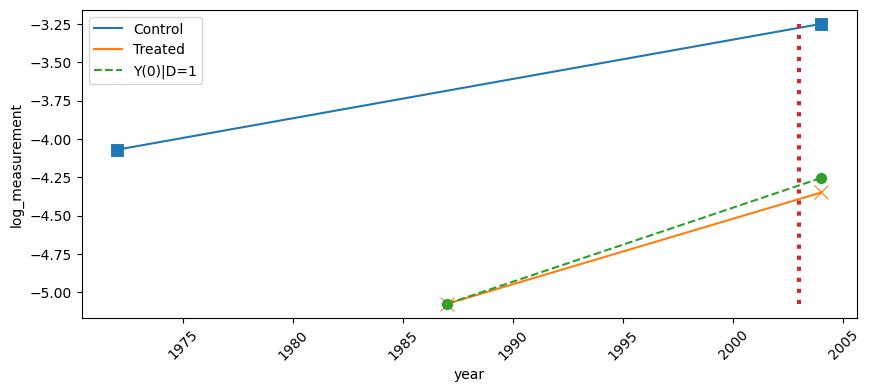

In [645]:
plt.figure(figsize=(10, 4))

sns.scatterplot(data=did_plt.query("treated==0"), x="year", y=outcome_var, s=100, color="C0", marker="s")
sns.lineplot(data=did_plt.query("treated==0"), x="year", y=outcome_var, label="Control", color="C0")

sns.scatterplot(data=did_plt.query("treated==1"), x="year", y=outcome_var, s=100, color="C1", marker="x")
sns.lineplot(data=did_plt.query("treated==1"), x="year", y=outcome_var, label="Treated", color="C1")

plt.vlines(x=intervention_year, ymin=did_min, ymax=did_max, color="C3", ls="dotted", lw=3)

plt.scatter(did_data.loc[1, "year"], [did_data.loc[1, outcome_var][0], y0_est], color="C2", s=50)
plt.plot(did_data.loc[1, "year"], [did_data.loc[1, outcome_var][0], y0_est], color="C2", linestyle="dashed", label="Y(0)|D=1")

plt.xticks(rotation=45)
plt.legend()

## DiD and OLS

In [646]:
did_data_with_treated = (
    df.groupby(
        [treatment_var, "post"]
    ).agg(
        {outcome_var: "mean", "year": "min", "treated": "max"}
    ).reset_index()
)
did_data_with_treated

,target_region,post,log_measurement,year,treated
0,0,0,-4.069850,1972,0
1,0,1,-3.248071,2004,0
2,1,0,-5.075441,1987,1
3,1,1,-4.348512,2004,1


### DiD Estimation

In [647]:
import statsmodels.formula.api as smf

model = smf.ols(
    f"{outcome_var} ~ treated*post", data=did_data_with_treated
).fit()
model.params["treated:post"], model.summary()

/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


(-0.09485024489486715,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        log_measurement   R-squared:                       1.000
 Model:                            OLS   Adj. R-squared:                    nan
 Method:                 Least Squares   F-statistic:                       nan
 Date:                Wed, 28 Aug 2024   Prob (F-statistic):                nan
 Time:                        18:13:55   Log-Likelihood:                 128.15
 No. Observations:                   4   AIC:                            -248.3
 Df Residuals:                       0   BIC:                            -250.7
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------

## DiD and unit-fixed effect model

In [648]:
model = smf.ols(
    f"{outcome_var} ~ treated:post + C({treatment_var}) + C(post)", data=did_data_with_treated
).fit()
model.params["treated:post"], model.summary()

/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


(-0.09485024489486715,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        log_measurement   R-squared:                       1.000
 Model:                            OLS   Adj. R-squared:                    nan
 Method:                 Least Squares   F-statistic:                       nan
 Date:                Wed, 28 Aug 2024   Prob (F-statistic):                nan
 Time:                        18:13:55   Log-Likelihood:                 128.15
 No. Observations:                   4   AIC:                            -248.3
 Df Residuals:                       0   BIC:                            -250.7
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------------------

## DiD and Block Design

In [649]:
df.assign(
    treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
).astype(
    {"year":"str"}
).assign(
    treated=df["treated"]*df["post"]
)

,log_measurement,year,treated,post,density,target_region,neuston_net
0,-4.017384,2015,0,1,Medium,0,0
2,-4.342806,2006,0,1,Medium,0,0
6,-0.459426,2007,0,1,Medium,0,1
7,-4.751353,2011,0,1,Medium,0,1
9,-5.420485,2019,0,1,Low,0,1
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,0,0
20416,-5.521461,2014,0,1,Low,0,0
20419,-4.509860,2015,0,1,Medium,0,0
20420,-3.835062,2001,0,0,Medium,1,1


In [650]:
df

,log_measurement,year,treated,post,density,target_region,neuston_net
0,-4.017384,2015,0,1,Medium,0,0
2,-4.342806,2006,0,1,Medium,0,0
6,-0.459426,2007,0,1,Medium,0,1
7,-4.751353,2011,0,1,Medium,0,1
9,-5.420485,2019,0,1,Low,0,1
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,0,0
20416,-5.521461,2014,0,1,Low,0,0
20419,-4.509860,2015,0,1,Medium,0,0
20420,-3.835062,2001,1,0,Medium,1,1


In [651]:
df3 = df.assign(
    treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
).astype(
    {"year":"str"}
).assign(
    treated=df["treated"]*df["post"]
)

In [652]:
treatment_var

'target_region'

In [653]:
df3 = df3.dropna(subset=[treatment_var])


In [654]:
df3

,log_measurement,year,treated,post,density,target_region,neuston_net
0,-4.017384,2015,0,1,Medium,0,0
2,-4.342806,2006,0,1,Medium,0,0
6,-0.459426,2007,0,1,Medium,0,1
7,-4.751353,2011,0,1,Medium,0,1
9,-5.420485,2019,0,1,Low,0,1
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,0,0
20416,-5.521461,2014,0,1,Low,0,0
20419,-4.509860,2015,0,1,Medium,0,0
20420,-3.835062,2001,0,0,Medium,1,1


In [655]:
df3[df3["year"].isin(["2021", "2022"])]

,log_measurement,year,treated,post,density,target_region,neuston_net
181,-3.068755,2021,0,1,Medium,0,0
245,-0.092115,2021,0,1,Medium,0,0
306,-2.336318,2022,0,1,Medium,0,1
321,-0.830113,2021,0,1,Medium,0,0
393,-0.206558,2021,0,1,Medium,0,0
...,...,...,...,...,...,...,...
20041,-1.852612,2021,0,1,Medium,0,1
20117,-2.701273,2021,0,1,Medium,0,1
20286,-2.363333,2022,0,1,Medium,0,1
20388,-1.072945,2021,0,1,Medium,0,0


In [656]:
df4 = df3.groupby([treatment_var, "year"]).agg({outcome_var: "mean"}) #.reset_index()
df4

log_measurement
target_region year                 
0             1972        -4.221861
              1973        -4.689538
              1986        -3.001992
              1987        -4.023693
              1989        -4.102478
              1990        -4.179098
              1991        -3.890752
              1992        -4.212127
              1993        -4.069336
              1994        -4.343191
              1995        -3.971828
              1996        -3.607522
              1997        -3.876448
              1998        -4.357379
              1999        -3.907719
              2000        -4.045391
              2001        -4.025121
              2002        -4.430723
              2003        -4.308525
              2004        -4.456492
              2005        -4.167802
              2006        -4.739985
              2007        -4.245898
              2008        -4.481266
              2009        -3.464450
              2010        -2.789048
              2011        -3.062149
              2012        -3.048913
              2013        -1.288982
              2014        -3.899576
              2015        -2.759144
              2016        -3.551958
              2017        -2.332974
              2018        -2.587442
              2019        -2.451795
              2020        -2.418109
              2021        -1.830879
              2022        -3.297970
1             1987        -5.056555
              1989        -5.365995
              1990        -5.444500
              1991        -5.467754
              1992        -5.092289
              1993        -5.277655
              1994        -5.234888
              1995        -4.921982
              1996        -4.671041
              1997        -5.173982
              1998        -5.294699
              1999        -4.811461
              2000        -5.054235
              2001        -5.008112
              2002        -4.964968
              2003        -4.908958
              2004        -4.934048
              2005        -4.817642
              2006        -4.553608
              2007        -4.692053
              2008        -5.469585
              2013        -4.140548
              2014        -5.237175
              2015        -3.311145
              2016        -4.503368
              2017        -1.282895
              2018        -5.222468
              2021        -3.490258

In [657]:
df5 = df3.set_index([treatment_var, "year"]).join(
    df4, on=[treatment_var, "year"], rsuffix="_mean", how="left"
).drop(columns=outcome_var).rename(columns={f"{outcome_var}_mean": outcome_var}).drop_duplicates().loc[:, ["treated", "post", outcome_var]].drop_duplicates().reset_index()
# check duplicates
# df5[df5.duplicated(subset=[treatment_var, "year"], keep=False)]
df5

,target_region,year,treated,post,log_measurement
0,0,2015,0,1,-2.759144
1,0,2006,0,1,-4.739985
2,0,2007,0,1,-4.245898
3,0,2011,0,1,-3.062149
4,0,2019,0,1,-2.451795
5,0,2005,0,1,-4.167802
6,0,2001,0,0,-4.025121
7,0,2018,0,1,-2.587442
8,0,1998,0,0,-4.357379
9,0,1996,0,0,-3.607522


In [658]:
df5.pivot(
    index=treatment_var, columns="year", values="treated"
    # index=["year", columns=treatment_var, values="treated"
).reset_index().fillna(0.0) #.loc[df5["Regions"] == "Gulf of California", :]

year,target_region,1972,1973,1986,1987,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [660]:
df5[df5[treatment_var] == treatment_var_value]

,target_region,year,treated,post,log_measurement
17,1,1999,0,0,-4.811461
18,1,2003,0,0,-4.908958
19,1,1993,0,0,-5.277655
25,1,1998,0,0,-5.294699
26,1,1987,0,0,-5.056555
29,1,2014,1,1,-5.237175
31,1,2000,0,0,-5.054235
36,1,2015,1,1,-3.311145
41,1,2006,1,1,-4.553608
42,1,2002,0,0,-4.964968


In [661]:
df5.assign(
    treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
).astype(
    {"year":"str"}
).assign(
    treated=df["treated"]*df["post"]
).pivot(
    index=treatment_var, columns="year", values="treated"
).reset_index().fillna(0.0).sort_values(
    max(df["year"].astype(str)), ascending=False
).reset_index(
).drop(
    columns=[treatment_var]
).rename(
    columns={"index": treatment_var}
).set_index(
    treatment_var
)

year,1972,1973,1986,1987,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
target_region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> TODO bug fix for treatment line and vline

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5]),
 [Text(0.5, 0, '1972'),
  Text(1.5, 0, '1973'),
  Text(2.5, 0, '1986'),
  Text(3.5, 0, '1987'),
  Text(4.5, 0, '1989'),
  Text(5.5, 0, '1990'),
  Text(6.5, 0, '1991'),
  Text(7.5, 0, '1992'),
  Text(8.5, 0, '1993'),
  Text(9.5, 0, '1994'),
  Text(10.5, 0, '1995'),
  Text(11.5, 0, '1996'),
  Text(12.5, 0, '1997'),
  Text(13.5, 0, '1998'),
  Text(14.5, 0, '1999'),
  Text(15.5, 0, '2000'),
  Text(16.5, 0, '2001'),
  Text(17.5, 0, '2002'),
  Text(18.5, 0, '2003'),
  Text(19.5, 0, '2004'),
  Text(20.5, 0, '2005'),
  Text(21.5, 0, '2006'),
  Text(22.5, 0, '2007'),
  Text(23.5, 0, '2008'),
  Text(24.5, 0, '2009'),
  Text(25.5, 0, '2010'),
  Text(26.5, 0, '2011'),
  Text(27.5, 0, '2012'),
  Text(28.5, 0, '2013'),
  Text(29.5, 0, '2014')

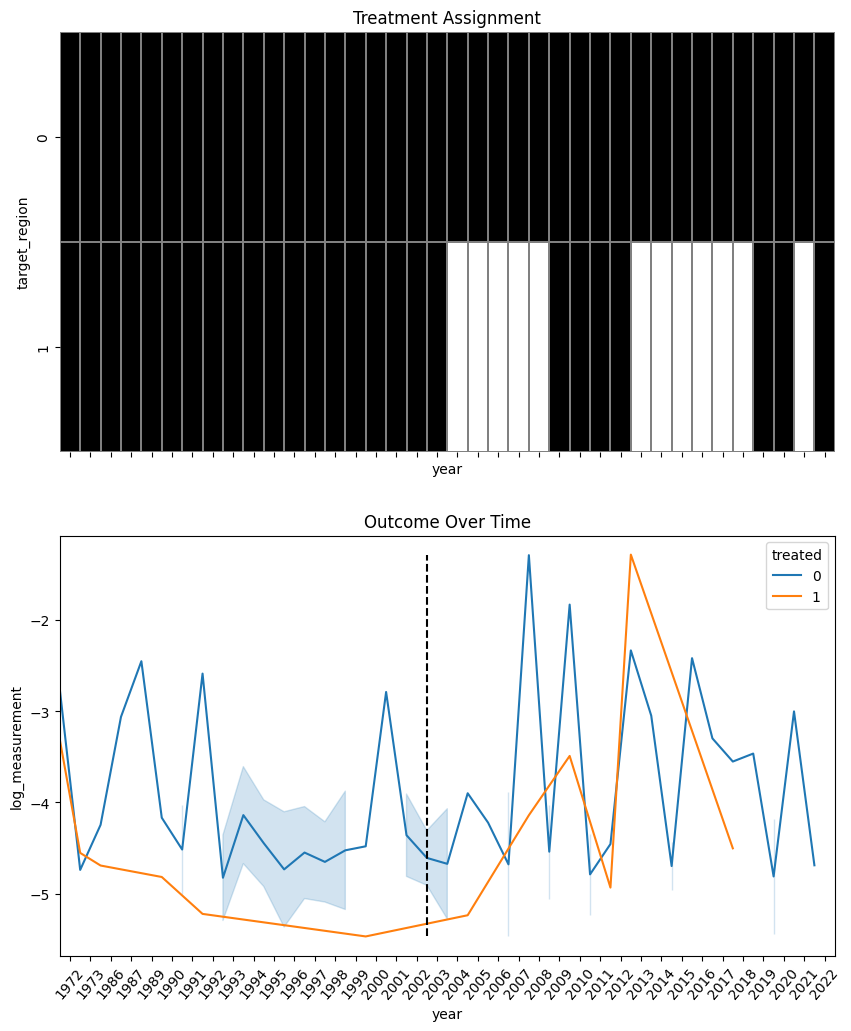

In [662]:
plt_df = df5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

heat_plt = (
    plt_df.assign(
        treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
    ).astype(
        {"year":"str"}
    ).assign(
        treated=plt_df["treated"]*plt_df["post"]
    ).pivot(
        index=treatment_var, columns="year", values="treated"
    ).reset_index().fillna(0.0).sort_values(
        max(plt_df["year"].astype(str)), ascending=False
    ).reset_index().drop(
        columns=[treatment_var]
    ).rename(
        columns={"index": treatment_var}
    ).set_index(treatment_var)
)

sns.heatmap(heat_plt, cmap="gray", linewidths=0.01, linecolor="0.5", ax=ax1, cbar=False)

ax1.set_title("Treatment Assignment")

years = sns.lineplot(data=plt_df.astype({"year":"str"}),
             x="year", y=outcome_var, hue="treated", ax=ax2)

loc = plticker.MultipleLocator(base=2.0)
# ax2.xaxis.set_major_locator(loc)
ax2.vlines(str(intervention_year), plt_df[outcome_var].min(), plt_df[outcome_var].max(), color="black", ls="dashed", label="Interv.")
ax2.set_title("Outcome Over Time")

plt.xticks(rotation=50)

In [663]:
m = smf.ols(f"{outcome_var} ~ treated*post", data=df).fit()
m.params["treated:post"]

-0.09485024489486714

### DiD estimation using unit-fixed effect model

In [664]:
m = smf.ols(f"{outcome_var} ~ treated*post + C({treatment_var}) + {covars_except_treatment}", data=df).fit()
m.params["treated:post"]

0.3100597517341557

### turn around from optimistic standard error to clustered standard error
> make Confidential Interval broader

In [665]:
df = df.dropna(subset=treatment_var)

In [666]:
m = smf.ols(
    f"{outcome_var} ~ treated*post + C({treatment_var}) + {covars_except_treatment}", data=df
).fit(cov_type="cluster", cov_kwds={"groups": df[treatment_var]})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 0.3100597517341557


/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1885: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


0   -6176.494553
1    6177.114673
Name: treated:post, dtype: float64

In [667]:
m = smf.ols(
    f"{outcome_var} ~ treated*post + C({treatment_var}) + C(year)", data=did_data_with_treated
).fit(cov_type="cluster", cov_kwds={"groups": did_data_with_treated[treatment_var]})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: -0.258028296480588


/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1885: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


0   NaN
1   NaN
Name: treated:post, dtype: float64

### Block bootstrap
> Sampling with replacement, 95 percentile Confidential Interval of DiD Estimation

In [668]:
def block_sample(df, unit_col):
    
    units = df[unit_col].unique()
    sample = np.random.choice(units, size=len(units), replace=True) 
    
    return (df
            .set_index(unit_col)
            .loc[sample]
            .reset_index(level=[unit_col]))

In [669]:
from joblib import Parallel, delayed

def block_bootstrap(data, est_fn, unit_col,
                    rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(block_sample(data, unit_col=unit_col))
        for _ in range(rounds))
    
    return np.percentile(stats, pcts)

In [670]:
def est_fn(df):
    m = smf.ols(f'{outcome_var} ~ treated:post + C({treatment_var}) + {covars_except_treatment}',
                data=df).fit()
    return m.params["treated:post"]

block_bootstrap(df, est_fn, treatment_var)

array([-6.93842901e+11,  3.12130438e-01])